In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress 

In [32]:
#get ur shit togther and actually finish these all today plzzz
#i)Histogram plots of the results from each of the tests conducted, that enable the reader to visualise the results and demonstrate that there are no issues (e.g. outliers)
#ii)Make three scatter plots showing the ANS scores vs other scores.
#iii)Table showing the results of three tests measuring correlation between ANS and the other cognitive tests (using the Spearman rank-order method)
#e.g. two columns: measured correlation value and significance (p-value), three rows for each of the tests (ANS vs maths, ANS vs correlation, ANS vs spatial reasoning).


In [33]:
#first, we need to identify if there are any outliers before we graph histograms showing distribution
#Here, we use Statistical Methods,  IQR
ans= pd.read_csv("ANS test.csv")
math= pd.read_csv("maths data.csv")
memory= pd.read_csv("memory_test.csv")
test_1 = ans[["Correct response"]]
test_2 = math[["correct_answers"]]
test_3 = memory[["n_correct_answers"]]
def outlier (test):
    q1, q3 = np.percentile(test, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = []
    for i in test:
        if i < "lower_bound" or i > "upper_bound":
            outliers.append(i)

print(outlier(test_1))
print(outlier(test_2))
print(outlier(test_3))

None
None
None


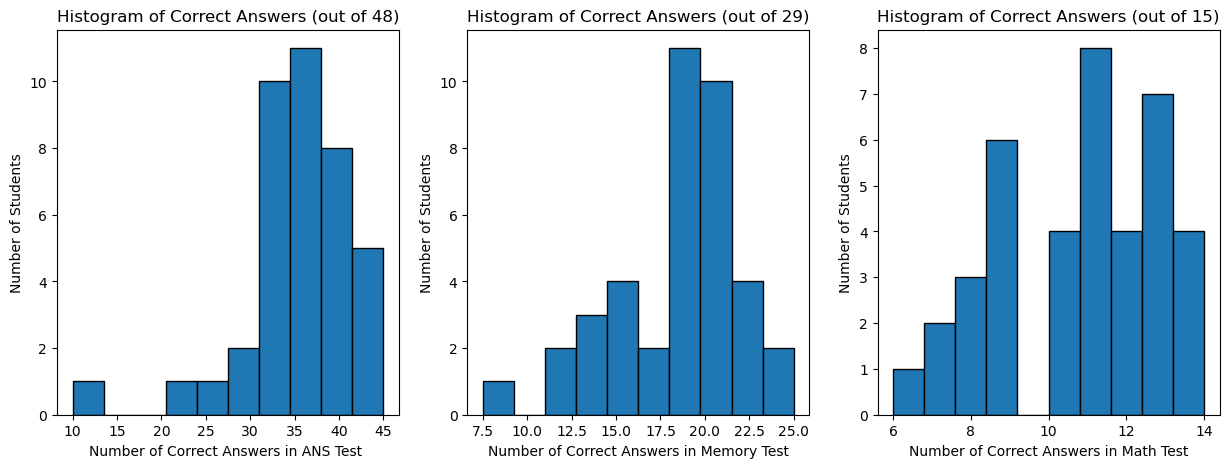

In [23]:
#Since there are no outliers, we proceed to graph histograms showing distribution of correct answers
#I want to create a plot with 3 histograms in a row to make it clearer
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ANS_srt = ans[["User id", "Correct response"]].set_index("User id")
ax[0].hist(ANS_srt, bins = 10, range=(10, 45), edgecolor='black')
ax[0].set_xlabel("Number of Correct Answers in ANS Test")
ax[0].set_ylabel("Number of Students")
ax[0].set_title("Histogram of Correct Answers (out of 48)")
memory_srt = memory[["ID", "n_correct_answers"]].set_index("ID")
ax[1].hist(memory_srt, bins = 10, range=(7.5, 25), edgecolor='black')
ax[1].set_xlabel("Number of Correct Answers in Memory Test")
ax[1].set_ylabel("Number of Students")
ax[1].set_title("Histogram of Correct Answers (out of 29)")
math_srt = math[["user_id", "correct_answers"]].set_index("user_id")
ax[2].hist(math_srt, bins = 10, range=(6, 14), edgecolor='black')
ax[2].set_xlabel("Number of Correct Answers in Math Test")
ax[2].set_ylabel("Number of Students")
ax[2].set_title("Histogram of Correct Answers (out of 15)")

plt.show()

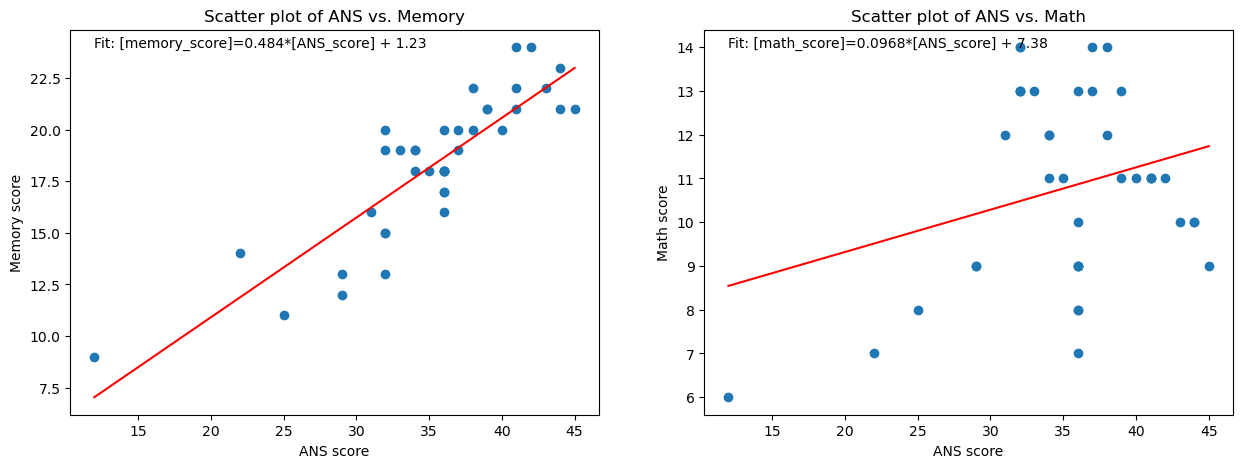

In [49]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ANS_merged_memory = ANS_srt.merge(memory_srt, left_index=True, right_index=True)
ANS_merged_math = ANS_srt.merge(math_srt, left_index=True, right_index=True)
ax[0].scatter(ANS_merged_memory["Correct response"], ANS_merged_memory["n_correct_answers"])
ax[0].set_xlabel("ANS score")
ax[0].set_ylabel("Memory score")
ax[0].set_title("Scatter plot of ANS vs. Memory")
ax[1].scatter(ANS_merged_math["Correct response"], ANS_merged_math["correct_answers"])
ax[1].set_xlabel("ANS score")
ax[1].set_ylabel("Math score")
ax[1].set_title("Scatter plot of ANS vs. Math")
(slope1, intercept1, rvalue1, pvalue1, stderr1) = linregress(ANS_merged_memory["Correct response"], ANS_merged_memory["n_correct_answers"])
(slope2, intercept2, rvalue2, pvalue2, stderr2) = linregress(ANS_merged_math["Correct response"], ANS_merged_math["correct_answers"])
# to draw line we take x values at each end of the plot
x0 = 12
x1 = 45

# then use eqn to find corresponding y-values
y0 = x0*slope1+intercept1
y1 = x1*slope1+intercept1

# we can now plot a line from (x0,y0) to (x1,y1)
ax[0].text(12,24, f"Fit: [memory_score]={slope1:.3g}*[ANS_score] + {intercept1:.3g}")
lines = ax[0].plot([x0,x1],[y0,y1],'r-')

y0 = x0*slope2+intercept2
y1 = x1*slope2+intercept2

# we can now plot a line from (x0,y0) to (x1,y1)
ax[1].text(12,14, f"Fit: [math_score]={slope2:.3g}*[ANS_score] + {intercept2:.3g}")
lines = ax[1].plot([x0,x1],[y0,y1],'r-')


In [50]:
#data analysis
rsquared1 = rvalue1*rvalue1
rsquared2 = rvalue2*rvalue2
print(f"R-squared value is {rsquared1:.3g}")
print(f"R-squared value is {rsquared2:.3g}")

R-squared value is 0.749
R-squared value is 0.0792
